# Model to accurately detect Melanoma
Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis

### Import the required libraries

In [9]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Mounting the Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import os
os.chdir('/content/drive/My Drive/cnn/')

In [10]:
folderpath = '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/'
data_dir_train = pathlib.Path(folderpath+"Train")
data_dir_test = pathlib.Path(folderpath+'Test')

In [7]:
## some reuired constants
batch_size = 32
img_height = 180
img_width = 180
batch_size = 32
num_classes = 10

In [11]:
## checking number of images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Spliting the data for training and testing


In [12]:
#training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
#training data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Getting classes from from training data

In [14]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the resized images from the training data

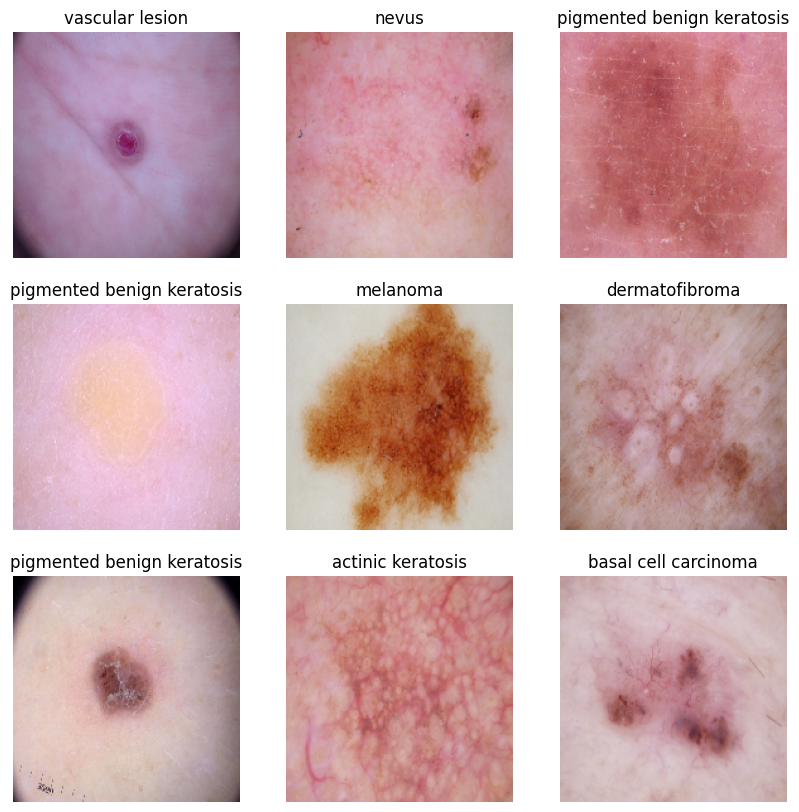

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Initialing and compiling the model and displaying summary

In [18]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 250s 1s/step - loss: 1.9306 - accuracy: 0.2952 - val_loss: 1.6328 - val_accuracy: 0.4027
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5153 - accuracy: 0.4542 - val_loss: 1.5180 - val_accuracy: 0.4832
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4056 - accuracy: 0.4983 - val_loss: 1.6570 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3451 - accuracy: 0.5190 - val_loss: 1.3592 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2190 - accuracy: 0.5742 - val_loss: 1.3498 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1275 - accuracy: 0.6021 - val_loss: 1.5030 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1148 - accuracy: 0.6094 - val_loss: 1.4473 - val_accuracy: 0.5145
Epoch 8/20
56

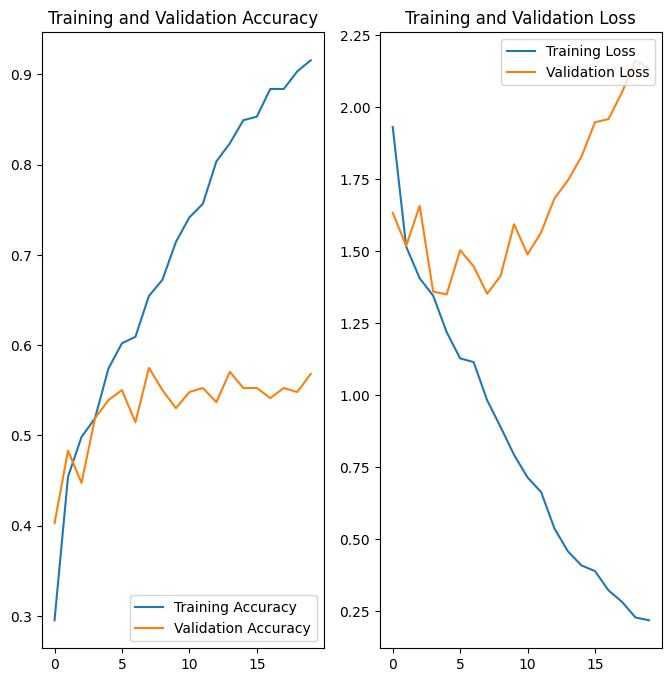

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation
The model is overfitting and though the accuracy of training data is high the difference of accuracy for training and validation data is very high

# Trying Flip Augmentation and dropout startegy

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### Visualizing the Horizontally augmented data

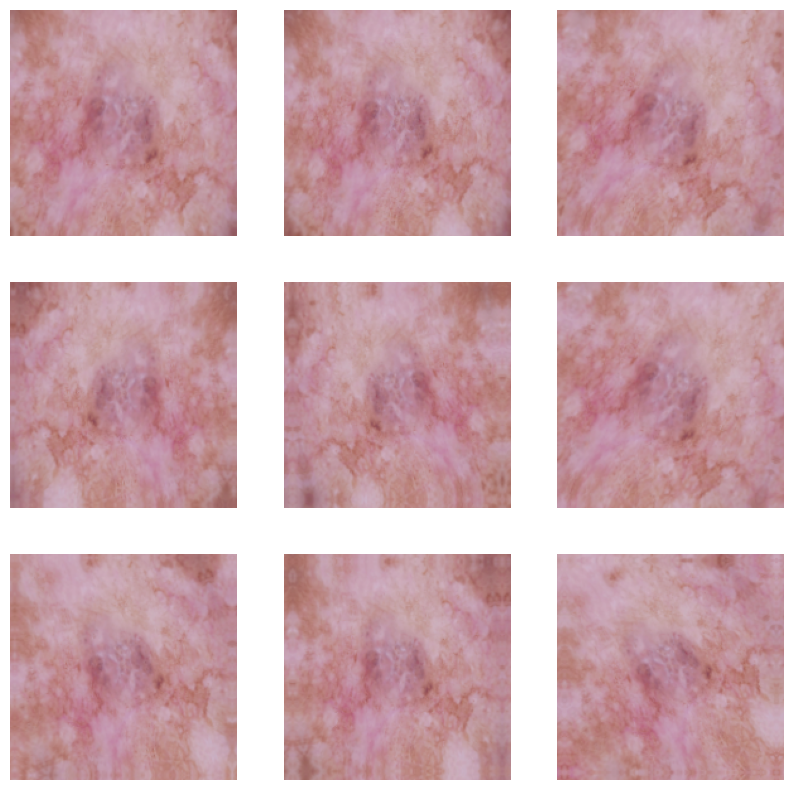

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Initialing and compiling the model and displaying summary

In [25]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 36ms/step - loss: 1.8143 - accuracy: 0.3365 - val_loss: 1.6065 - val_accuracy: 0.4340
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5951 - accuracy: 0.4364 - val_loss: 1.4691 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4322 - accuracy: 0.4967 - val_loss: 1.4752 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4257 - accuracy: 0.4872 - val_loss: 1.4020 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3215 - accuracy: 0.5190 - val_loss: 1.4091 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2927 - accuracy: 0.5363 - val_loss: 1.3013 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.2534 - accuracy: 0.5569 - val_loss: 1.4169 - val_accuracy: 0.4944
Epoch 8/20
56

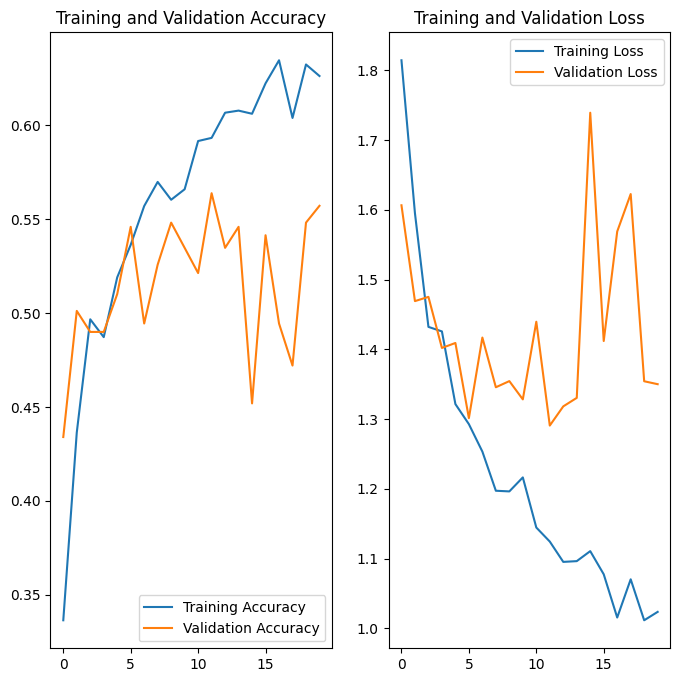

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation
The accuracy of model on training data has reduced. But the accuracy difference between the training and test data has reduced drastically. So there is no overing in this model. The Accuracy is close to flipping of coin. So this model need some more improvement

# Improving the model with Augmentation.(Increasing the count of images in each category)

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [30]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


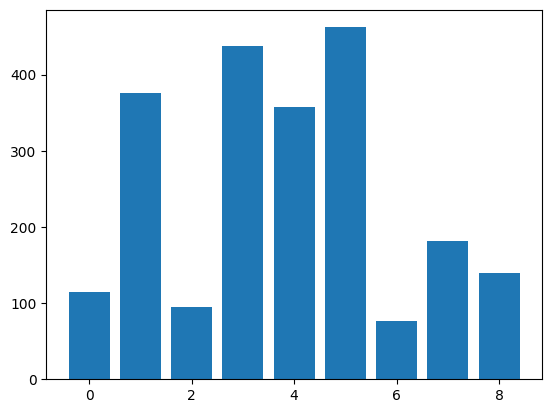

In [31]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [32]:
!pip install Augmentor

In [33]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79B2E8704C10>: 100%|██████████| 500/500 [00:24<00:00, 20.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79B2E8427520>: 100%|██████████| 500/500 [00:23<00:00, 21.49 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79B3ED5828C0>: 100%|██████████| 500/500 [00:23<00:00, 21.20 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79B2E8476740>: 100%|██████████| 500/500 [01:27<00:00,  5.73 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x79B2E84B7BE0>: 100%|██████████| 500/500 [01:16<00:00,  6.51 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79B38B35D9C0>: 100%|██████████| 500/500 [00:17<00:00, 27.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79B2E86E6740>: 100%|██████████| 500/500 [00:45<00:00, 11.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79B2E8704C10>: 100%|██████████| 500/500 [00:17<00:00, 28.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79B2E84A6F50>: 100%|██████████| 500/500 [00:18<00:00, 27.45 Samples/s]


In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [35]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_08b588e1-3c44-4243-b797-406b2ef347fd.jpg',
 '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_ca41ad19-8d4c-47f1-9856-779d3e9c7e2c.jpg',
 '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_66b79959-2326-4cf2-abdb-a71c6c0185d1.jpg',
 '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_718dace9-1249-4cb2-b6d7-646e2df1cf64.jpg',
 '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_00298

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [37]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_08b588e1-3c44-4243-b797-406b2ef347fd.jpg',
 '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_ca41ad19-8d4c-47f1-9856-779d3e9c7e2c.jpg',
 '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_66b79959-2326-4cf2-abdb-a71c6c0185d1.jpg',
 '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_718dace9-1249-4cb2-b6d7-646e2df1cf64.jpg',
 '/content/drive/My Drive/cnn/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_00298

In [38]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-39-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [41]:
batch_size = 32
img_height = 180
img_width = 180

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [45]:
## compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
epochs = 30
## Train model 50 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 36s 29ms/step - loss: 1.8789 - accuracy: 0.2982 - val_loss: 1.3690 - val_accuracy: 0.5548
Epoch 2/30
169/169 [==============================] - 4s 26ms/step - loss: 1.3828 - accuracy: 0.4815 - val_loss: 1.2485 - val_accuracy: 0.5749
Epoch 3/30
169/169 [==============================] - 5s 30ms/step - loss: 1.1436 - accuracy: 0.5738 - val_loss: 1.1229 - val_accuracy: 0.6107
Epoch 4/30
169/169 [==============================] - 5s 27ms/step - loss: 1.0094 - accuracy: 0.6328 - val_loss: 0.9206 - val_accuracy: 0.6846
Epoch 5/30
169/169 [==============================] - 4s 26ms/step - loss: 0.8589 - accuracy: 0.6988 - val_loss: 0.8294 - val_accuracy: 0.6957
Epoch 6/30
169/169 [==============================] - 4s 27ms/step - loss: 0.7165 - accuracy: 0.7407 - val_loss: 0.7647 - val_accuracy: 0.7494
Epoch 7/30
169/169 [==============================] - 5s 28ms/step - loss: 0.5863 - accuracy: 0.7930 - val_loss: 0.6689 - val_accuracy: 0.794

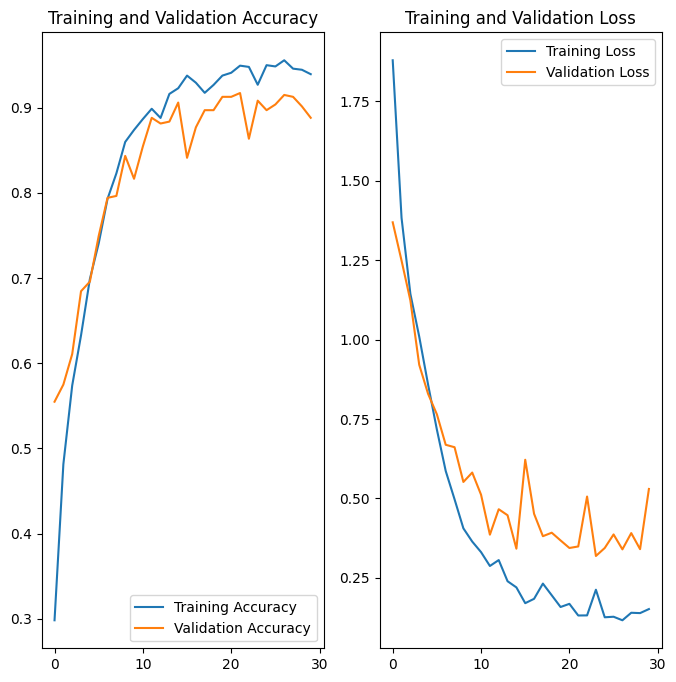

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Observation
With increaing avaibility of traing data the accurracy has increase drastically. There is no overfitting

##Testing on some randam data

In [ ]:
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
parent_directory = data_dir_test  # Replace with the path to your image
subdirectories = [subdir for subdir in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, subdir))]

# Choose a random subdirectory
chosen_subdirectory = random.choice(subdirectories)

# Construct the full path to the chosen subdirectory
subdirectory_path = os.path.join(parent_directory, chosen_subdirectory)

# List all files in the chosen subdirectory
file_list = os.listdir(subdirectory_path)

# Choose an image file from the list
chosen_file = random.choice(file_list)

# Construct the full path to the chosen image
img_path = os.path.join(subdirectory_path, chosen_file)
print (img_path)
# Load and preprocess the chosen image
img = image.load_img(img_path, target_size=(180, 180))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Add an extra dimension
img_array = preprocess_input(img_array)  # Normalize pixel values

# Make a prediction
predictions = model.predict(img_array)

# Decode the prediction
predicted_class = tf.argmax(predictions, axis=1).numpy()[0]

# Print the predicted class
print("Predicted Class:", predicted_class)